In [1]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

figsize = (14, 3.5)

import os
from sklearn.model_selection import GridSearchCV
from util import util
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from util import util
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Load data
fname = os.path.join('data', 'hpc.csv')
hpc = pd.read_csv(fname, parse_dates=['timestamp'])

# Identify input columns
inputs = hpc.columns[1:-1]
ninputs = len(inputs)

c_alarm, c_missed, tolerance = 1, 5, 12
cmodel =  util.HPCMetrics(c_alarm, c_missed, tolerance)

tr_end, val_end = 3000, 4500

hpcs = hpc.copy()
tmp = hpcs.iloc[:tr_end]
hpcs[inputs] = (hpcs[inputs] - tmp[inputs].mean()) / tmp[inputs].std()

trdata = hpcs.iloc[:tr_end]
valdata = hpcs.iloc[tr_end:val_end]
tsdata = hpcs.iloc[val_end:]

# Autoencoders for Anomaly Detection

## High Performance Computing

**High Performance Computing**

HPC refers to HW/SW infrastructures for particularly intensive workloads

<center><img src="assets/supercomputers.jpg" width=900px/></center>

## High Performance Computing

**HPC is (somewhat) distinct from cloud computing**

* Cloud computing is mostly about running (and scaling services)
* ...HPC is all about _performance_

Typical applications: simulation, massive data analysis, training large ML models

**HPC systems follow a batch computation paradigm**

* Users send _jobs_ to the systems (i.e. configuration for running a program)
* Jobs end in one of several _queues_
* A _job scheduler_ draws from the queue
* ...And dispatches jobs to computational _nodes_ for execution

## High Performance Computing

**HPC systems can be large and complex**

E.g. Leonardo, the 4-th most powerful supercompuer [(as of June 2023)](https://www.top500.org/lists/top500/list/2023/06/)

<center><img src="assets/leonardo.png" width=800px/></center>

* The system has 1,824,768 cores overall!

**Configuring (and maintaining the configuration) of these systems**

* ...Is of very important, as it has an impact on the performance
* ...And very challenging, due to their _scale_ and the to _node heterogeneity_ 

Hence the interest in _detecting anomalous conditions_

## The Dataset

**As an example, we will consider the DAVIDE system**

Small scale, energy-aware architecture:

* Top of the line components (at the time), liquid cooled
* An advanced monitoring and control infrastructure (ExaMon)
* ...Developed together with UniBo

The system went out of production in January 2020

**The monitoring system enables anomaly detection**

* Data is collected from a number of samples with high-frequency
* Long term storage only for averages over 5 minute intervals
* Anomalies correspond to unwanted configurations of the _frequency governor_
* ...Which can throttle performance to save power or prevent overheating

## A Look at the Dataset

**Our dataset refers to the non-idle periods of a single node**

In [2]:
print(f'#examples: {hpc.shape[0]}, #columns: {hpc.shape[1]}')
hpc.iloc[:3]

#examples: 6667, #columns: 161


,timestamp,ambient_temp,cmbw_p0_0,cmbw_p0_1,cmbw_p0_10,cmbw_p0_11,cmbw_p0_12,cmbw_p0_13,cmbw_p0_14,cmbw_p0_2,...,util_p0_5,util_p0_6,util_p0_8,util_p0_9,volt_v0_1,volt_v0_2,volt_v1_1,volt_v1_2,winkcnt_p0_2,anomaly
0,2018-03-05 22:45:00,0.165639,0.006408,0.012176,0.166835,0.238444,0.230092,0.145691,0.227682,0.000094,...,0.056146,0.007334,0.009948,0.015761,0.076402,0.727967,0.075536,0.787213,1.0,0
1,2018-03-05 22:50:00,0.139291,0.007772,0.057400,0.166863,0.238485,0.230092,0.145691,0.227682,0.176855,...,0.998460,0.742089,0.010209,0.019240,0.999908,0.727514,0.999856,0.787024,1.0,0
2,2018-03-05 22:55:00,0.141048,0.000097,0.000000,0.166863,0.238444,0.230092,0.145691,0.227682,0.252403,...,0.239957,0.838108,0.010262,0.025894,0.999918,0.727514,0.999870,0.787024,1.0,0


* This still a time series, but a _multivariate_ one

## A Look at the Dataset

**How to display a multivariate series? Approach #1: showing _individual columns_**

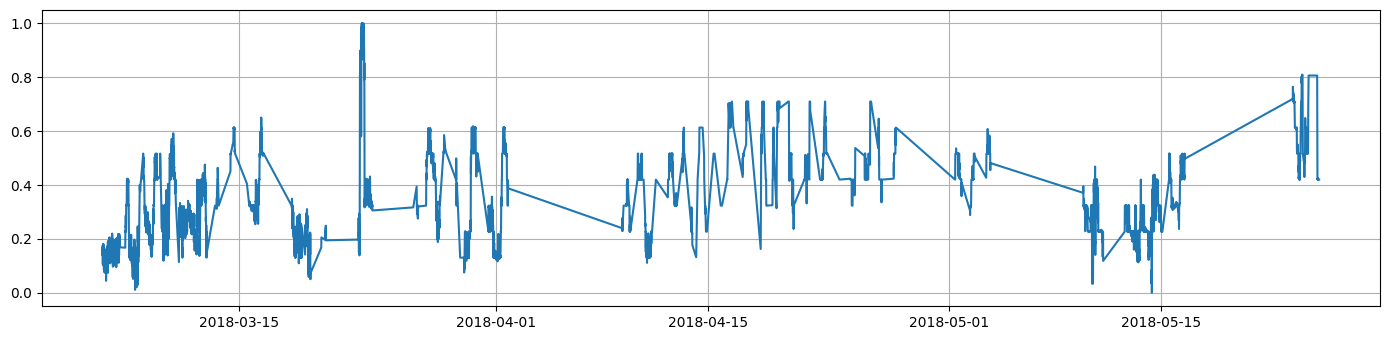

In [3]:
tmp = pd.Series(index=hpc['timestamp'], data=hpc[inputs[0]].values)
util.plot_series(tmp, figsize=figsize)

* The series contains significant gaps (i.e. the idle periods)

## A Look at the Dataset

**Approach #2: obtaining _statistics_**

In [4]:
hpc[inputs].describe()

,ambient_temp,cmbw_p0_0,cmbw_p0_1,cmbw_p0_10,cmbw_p0_11,cmbw_p0_12,cmbw_p0_13,cmbw_p0_14,cmbw_p0_2,cmbw_p0_3,...,util_p0_4,util_p0_5,util_p0_6,util_p0_8,util_p0_9,volt_v0_1,volt_v0_2,volt_v1_1,volt_v1_2,winkcnt_p0_2
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,...,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,0.357036,0.138162,0.060203,0.119616,0.160606,0.184970,0.118305,0.151434,0.143033,0.147800,...,0.509612,0.716533,0.766818,0.202598,0.202650,0.808665,0.481398,0.808170,0.512920,0.626519
std,0.166171,0.128474,0.090796,0.098597,0.128127,0.163190,0.104490,0.120793,0.125052,0.138610,...,0.479815,0.424887,0.400454,0.388927,0.389502,0.386906,0.379362,0.387440,0.400457,0.483765
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.227119,0.000073,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000117,0.000056,...,0.000200,0.198757,0.678980,0.000000,0.000000,0.999887,0.000000,0.999827,0.000000,0.000000
50%,0.323729,0.136095,0.000082,0.166835,0.238444,0.230092,0.145691,0.227682,0.174933,0.138148,...,0.517715,0.999260,0.999380,0.010074,0.009918,0.999908,0.727514,0.999856,0.787024,1.000000
75%,0.470254,0.261908,0.134976,0.166984,0.238566,0.230406,0.145908,0.227779,0.251910,0.299604,...,0.999523,0.999828,0.999907,0.016749,0.023519,0.999928,0.727514,0.999885,0.787024,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* No missing value, _normalized_ data

## A Look at the Dataset

**Approach #3: standardize, then use a _heatmap_**

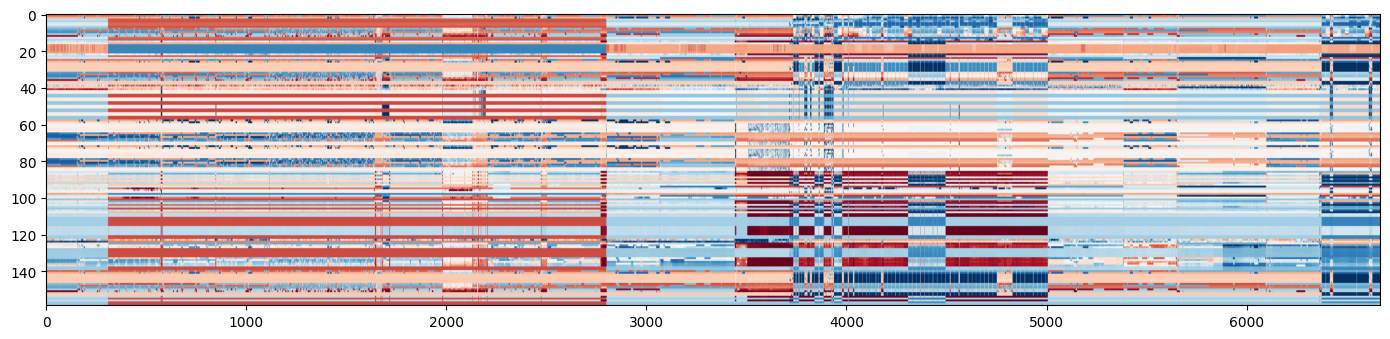

In [5]:
hpcsv = hpc.copy()
hpcsv[inputs] = (hpcsv[inputs] - hpcsv[inputs].mean()) / hpcsv[inputs].std()
util.plot_df_heatmap(hpcsv[inputs], figsize=figsize)

* White = mean, red = below mean, blue = above mean

## Anomalies

**There are three possible configurations of the frequency governor:**

* Mode 0 or "normal": frequency proportional to the workload
* Mode 1 or "power saving": frequency always at the minimum value
* Mode 2 or "performance": frequency always at the maximum value

**On this dataset, this information is known**

...And it will serve as our ground truth

* We will focus on discriminating normal from non-normal behavior
* I.e. we will treat both "power saving" and "performance" configurations as anomalous

**Detecting them will be _challenging_**

* Since the signals vary so much when the running job changes

## Anomalies

**We can plot the location of the anomalies:**

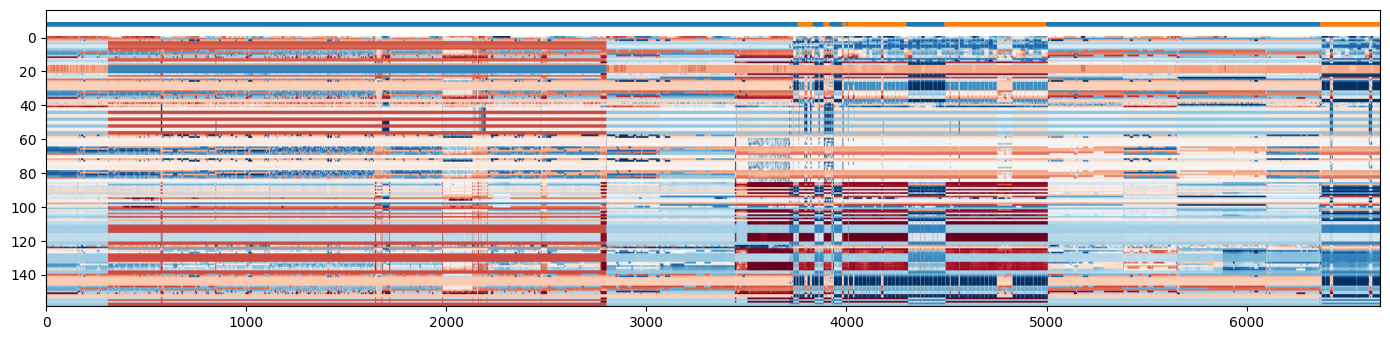

In [6]:
labels = pd.Series(index=hpcsv.index, data=(hpcsv['anomaly'] != 0), dtype=int)
util.plot_df_heatmap(hpcsv[inputs], labels, figsize=figsize)

* On the top, blue = normal, orange = anomaly

# Autoencoders for Anomaly Detection

## Autoencoders

**An autoencoder is _a type of neural network_**

The network is designed to _reconstruct its input vector_

* The input is some tensor $x$ and the output _should be_ the same tensor $x$

**Autoencoders can be broken down in two halves**

* An encoding part, i.e. $\mathit{encode}(x, \theta_e)$, mapping $x$ into a vector of _latent variables $z$_
* A decoding part, i.e. $\mathit{decode}(z, \theta_d)$, mapping $z$ into reconstructed input tensor

**Autoencoders are trained so as to satisfy:**

$$
\mathit{decode}(\mathit{encode}(\hat{x}_i, \theta_e), \theta_d) \simeq \hat{x}_i
$$

* I.e. $\mathit{decode}$, when applied to the output of $\mathit{encode}$
* ...Should approximately return the input vector itself

A nice introduction and tutorial about autoencoders can be found [on the Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html)

## Autoencoders

**Formally, we typically employ an MSE loss**

$$
L(\theta_e, \theta_d) = \sum_{i=1}^n \left\|\hat{x}_i - \mathit{decode}(\mathit{encode}(\hat{x}_i, \theta_e), \theta_d)\right\|_2^2
$$

* This is trivial to satisfy if both $\mathit{encode}$ and $\mathit{decode}$ learn an identity relation
* ...So we need to prevent that

**There are _two main approaches_ to avoid learning a trivial mapping**

* Using an _information bottleneck_, i.e. making sure that $z$ has fewer dimensions that $x$
* Use a regularization to enforce _sparse encodings_, e.g.:

$$
L(\theta_e, \theta_d) = \sum_{i=1}^n \left\|\hat{x}_i - \mathit{decode}(\mathit{encode}(\hat{x}_i, \theta_e), \theta_d)\right\|_2^2 + \alpha \| \mathit{encode}(x, \theta_e) \|_1
$$

## Autoencoders for Anomaly Detection

**Autoencoders can be used for anomaly detection**

...By using the _reconstruction error as an anomaly signal_, e.g.:

$$
\left\|x - \mathit{decode}(\mathit{encode}(x, \theta_e), \theta_d)\right\|_2^2 > \theta
$$

**This approach has some PROs and CONs:**

* Compared to KDE
  - Neural Networks have good _support for high dimensional data_
  - ...Plus _limited overfitting_ and _fast prediction/detection time_
  - However, error reconstruction can be _harder than density estimation_
* Compared to autoregressors
  - Reconstructing an input is _easier than predicting the future_
  - ...So, we tend to get higher reliability


## Autoencoders in Keras

**Let's build an autoencoder in practice (with tensorflow 2.0 and keras)**

First, we build the model

In [7]:
input_shape = (len(inputs), )
ae_x = keras.Input(shape=input_shape, dtype='float32')
ae_z = layers.Dense(64, activation='relu')(ae_x)
ae_y = layers.Dense(len(inputs), activation='linear')(ae_z)
ae = keras.Model(ae_x, ae_y)

In this case, we used the keras [functional API](https://keras.io/guides/functional_api/)

* `Input` builds the entry point for the input data
* `Dense` builds a fully connected layer
* "Calling" layer A with parameter B attaches B to A
* `Model` builds a model object with the specified input and output

## Autoencoders in Keras

**Then we compile (prepare for training) the model**

In [8]:
ae.compile(optimizer='adam', loss='mse')

**Finally we can start training:**

In [9]:
cb = [callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
history = ae.fit(trdata[inputs], trdata[inputs], validation_split=0.1,
                 callbacks=cb,
                 batch_size=32, epochs=20, verbose=0)

* We are using a callback to stop training early
* ...If no improvement on the validation set is observed for 3 epochs

## Autoencoders in Keras

**Let's have a look at the loss evolution over different epochs**

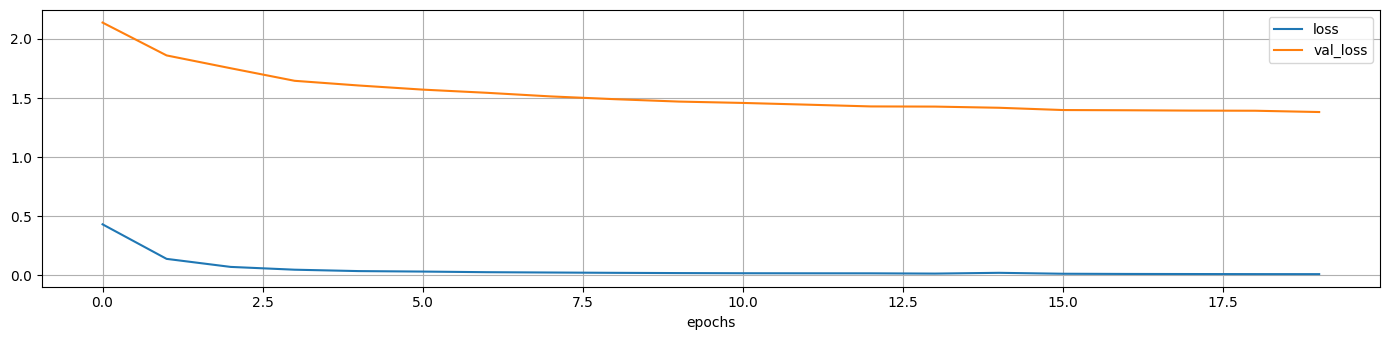

Final loss: 0.0102 (training), 1.3819 (validation)


In [10]:
util.plot_training_history(history, figsize=figsize)

## Autoencoders in Keras

**Finally, we can obtain the predictions**

In [11]:
preds = pd.DataFrame(index=hpcs.index, columns=inputs, data=ae.predict(hpcs[inputs], verbose=0))
preds.head()

,ambient_temp,cmbw_p0_0,cmbw_p0_1,cmbw_p0_10,cmbw_p0_11,cmbw_p0_12,cmbw_p0_13,cmbw_p0_14,cmbw_p0_2,cmbw_p0_3,...,util_p0_4,util_p0_5,util_p0_6,util_p0_8,util_p0_9,volt_v0_1,volt_v0_2,volt_v1_1,volt_v1_2,winkcnt_p0_2
0,-1.138980,-0.359113,0.189074,2.185054,2.667114,2.128118,2.406620,2.635181,-1.390873,-0.479664,...,-1.267148,-1.767165,-1.949468,1.926024,1.754319,-6.670276,2.291426,-6.126795,2.076773,2.271736
1,-0.989553,-0.802634,0.024643,2.254758,2.220580,2.250266,2.115175,2.128901,0.441165,-0.573394,...,0.943553,0.563379,-0.155363,2.008349,2.620871,0.098123,2.198638,0.078508,2.294818,2.309069
2,-1.139965,-0.909415,-0.296855,2.266429,2.333091,2.230960,2.324998,2.140663,0.627649,0.847198,...,0.952436,-0.489435,0.083574,2.146378,2.843071,0.312246,2.347672,0.224179,2.226497,2.366628
3,-1.133758,-1.029081,-0.620016,2.316810,2.205164,2.227934,2.302143,2.133055,0.709560,0.971466,...,1.214100,0.888311,-1.558515,2.077013,2.653521,0.216020,2.203426,0.320218,2.275842,2.183633
4,-1.065439,-0.934695,-0.533392,2.298864,2.268576,2.297478,2.258738,2.260001,0.751338,0.887770,...,1.064821,0.849326,-1.563725,2.021722,2.816547,0.213804,2.216938,0.238825,2.244732,2.262995


## Alarm Signal

**We can finally obtain our alarm signal, i.e. the sum of squared errors**

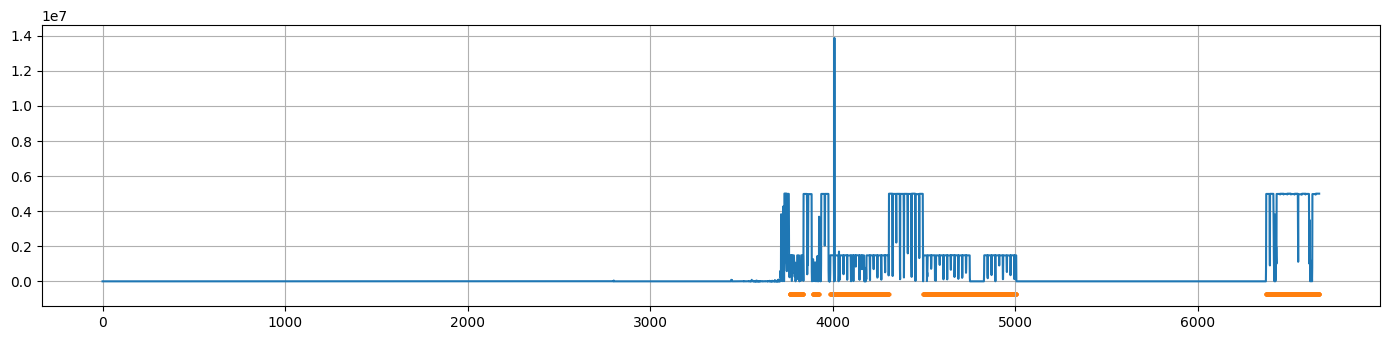

In [12]:
sse = np.sum(np.square(preds - hpcs[inputs]), axis=1)
signal_ae = pd.Series(index=hpcs.index, data=sse)
util.plot_signal(signal_ae, labels, figsize=figsize)

* It is actually quite similar to the KDE signal

## Threshold Optimization

**Then we can optimize the threshold as usual**

In [13]:
th_range = np.linspace(5e5, 1e6, 100)
th_ae, val_cost_ae = util.opt_threshold(signal_ae[tr_end:val_end],
                                        hpcs['anomaly'][tr_end:val_end],
                                        th_range, cmodel)
print(f'Best threshold: {th_ae:.3f}')
tr_cost_ae = cmodel.cost(signal_ae[:tr_end], hpcs['anomaly'][:tr_end], th_ae)
print(f'Cost on the training set: {tr_cost_ae}')
print(f'Cost on the validation set: {val_cost_ae}')
ts_cost_ae = cmodel.cost(signal_ae[val_end:], hpcs['anomaly'][val_end:], th_ae)
print(f'Cost on the test set: {ts_cost_ae}')

Best threshold: 944444.444
Cost on the training set: 0
Cost on the validation set: 248
Cost on the test set: 275


## Mutiple Signal Analysis

**But autoencoders do _more than just anomaly detection_!**

* Instead of having a single signal we have _many_
* So we can look at the _individual_ reconstruction errors

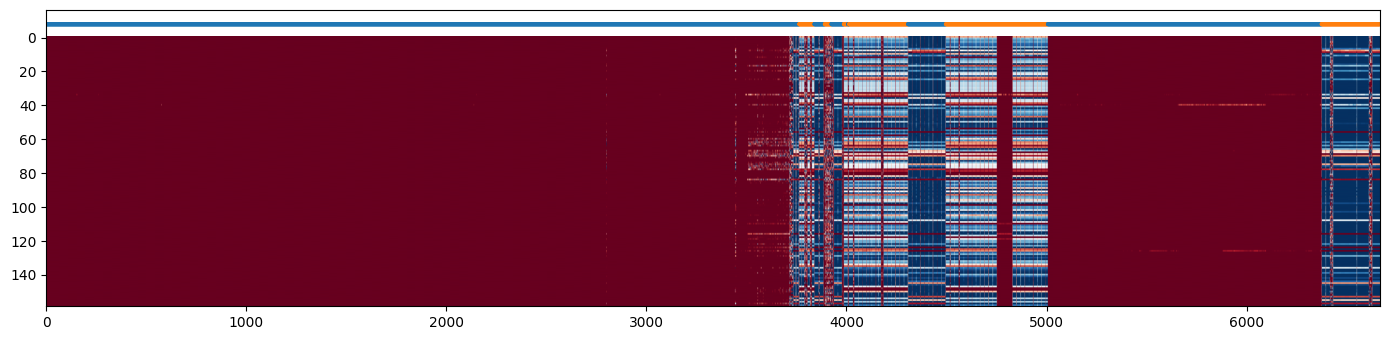

In [14]:
se = np.sqrt(np.square(preds - hpcs[inputs]))
signals_ae = pd.DataFrame(index=hpcs.index, columns=inputs, data=se)
util.plot_df_heatmap(signals_ae, labels, vmin=np.quantile(se, 0.25), vmax=np.quantile(se, 0.75), figsize=figsize)

## Mutiple Signal Analysis

**Reconstruction errors are often concentrated on a few signals**

* These correspond to the properties of the input vector that were harder to reconstruct
* ...And often they are useful clues about the _nature of the anomaly_

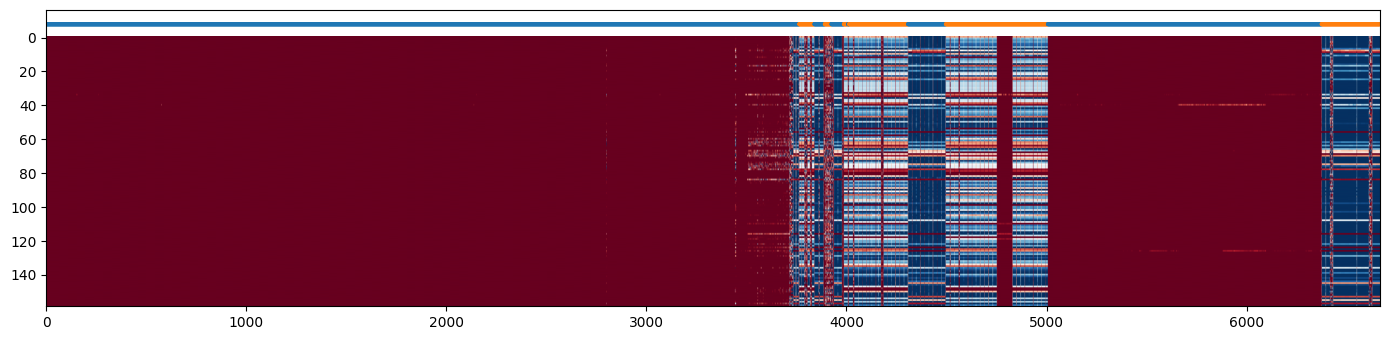

In [15]:
se = np.sqrt(np.square(preds - hpcs[inputs]))
signals_ae = pd.DataFrame(index=hpcs.index, columns=inputs, data=se)
util.plot_df_heatmap(signals_ae, labels, vmin=np.quantile(se, 0.25), vmax=np.quantile(se, 0.75), figsize=figsize)

## Multiple Signal Analysis

**Let's focus on the last _mode 1_ anomaly ("power saving" mode)**

Here are the 8 largest errors in descending order

In [16]:
last_mode_1 = hpcs.index[hpcs['anomaly']==1][-1]
se.iloc[last_mode_1].sort_values(ascending=False)[:8]

ips_p0_14     546.993023
ips_p0_10     503.793992
ips_p0_12     460.386792
ips_p0_11     381.779745
ips_p0_8      299.822581
ips_p0_9      246.854928
util_p0_8     229.356337
util_p0_11    205.467749
Name: 5006, dtype: float64

* They are mostly related to performance (e.g. "ips" - Instructions Per Second)
* ...As it should be!

## Multiple Signal Analysis

**Now, let's move to the last _mode 2_ anomaly ("performance" mode)**

Here are the 8 largest errors in descending order

In [17]:
last_mode_2 = hpcs.index[hpcs['anomaly']==2][-1]
se.iloc[last_mode_2].sort_values(ascending=False)[:8]

ips_p0_14    1090.933566
ips_p0_10    1000.667186
ips_p0_12     891.047341
ips_p0_11     763.514945
ips_p0_8      615.272785
ips_p0_9      510.884209
util_p0_8     237.609959
ips_p0_13     219.799444
Name: 6666, dtype: float64

* Again, they are performance related

## Multiple Signal Analysis

**Here are the _average errors_ for mode 1 anomalies**

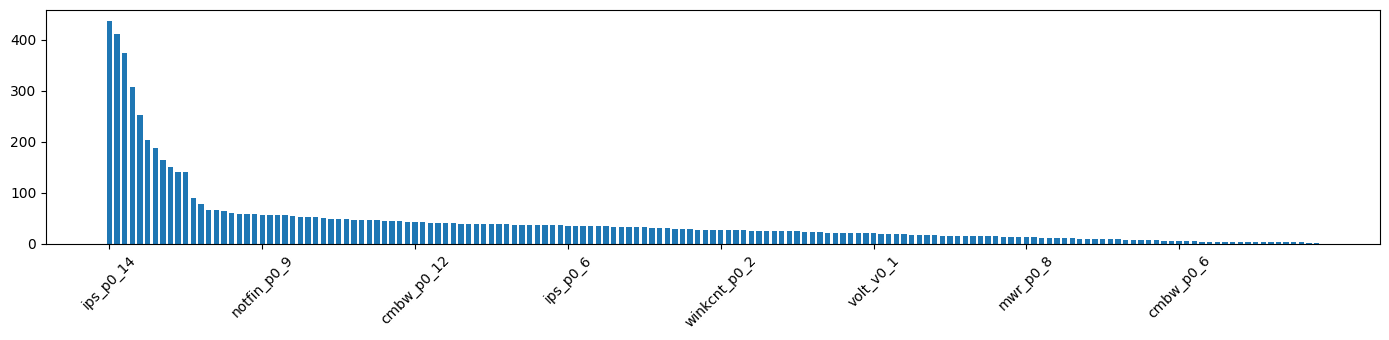

In [18]:
mode_1 = hpcs.index[hpcs['anomaly']==1]
tmp =  se.iloc[mode_1].mean().sort_values(ascending=False)
util.plot_bars(tmp, tick_gap=20, figsize=figsize)

* Errors are concentrated on a small number of features

## Multiple Signal Analysis

**These are the 20 _largest_ average errors for _mode 1_ anomalies**

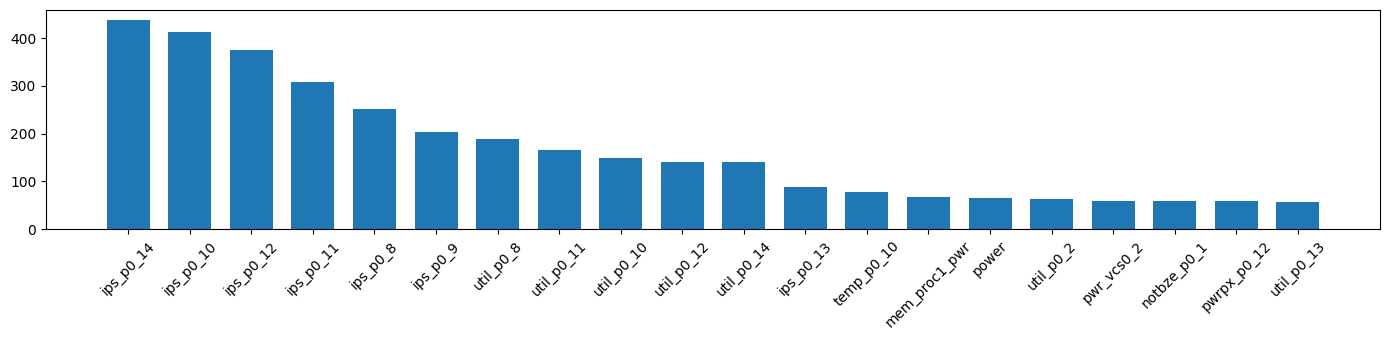

In [19]:
mode_1 = hpcs.index[hpcs['anomaly']==1]
tmp =  se.iloc[mode_1].mean().sort_values(ascending=False)
util.plot_bars(tmp.iloc[:20], figsize=figsize)

* The largest errors are on "ips", then on "util" (utilization)

## Multiple Signal Analysis

**Let's repeat the analysis for _mode 2_. Here are the _average errors_**

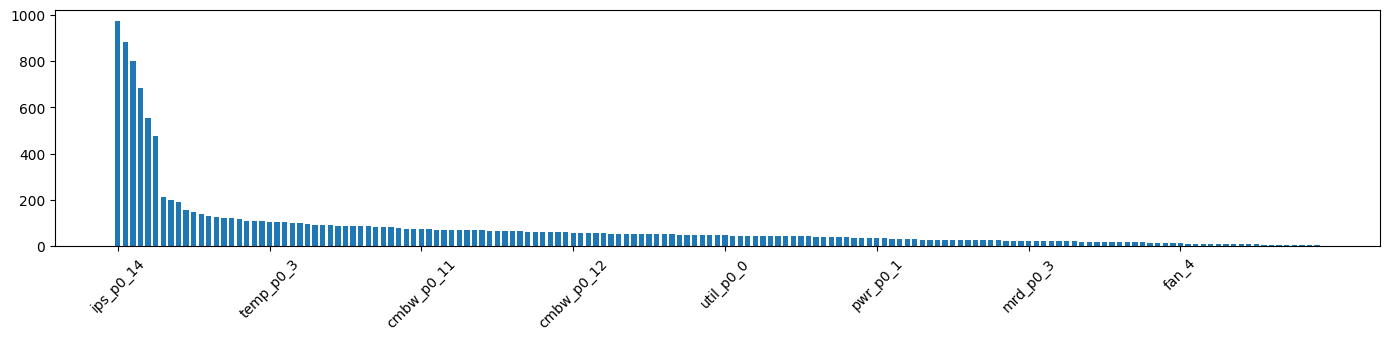

In [20]:
mode_2 = hpcs.index[hpcs['anomaly']==2]
tmp =  se.iloc[mode_2].mean().sort_values(ascending=False)
util.plot_bars(tmp, tick_gap=20, figsize=figsize)

* The situation is similar to mode 1

## Multiple Signal Analysis

**The 20 _largest_ average errors for _mode 2_**

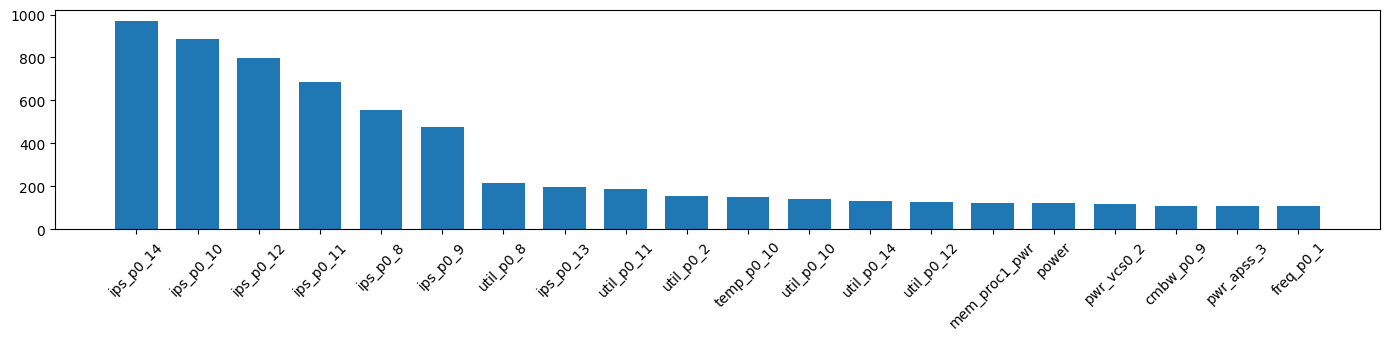

In [21]:
mode_2 = hpcs.index[hpcs['anomaly']==2]
tmp =  se.iloc[mode_2].mean().sort_values(ascending=False)
util.plot_bars(tmp.iloc[:20], figsize=figsize)

* The largest errors are on "ips", then on power signals

## Considerations

**Autoenders can be used for anomaly detection**

* The provide the usual benefits of Neural Networks
  - E.g. scalability, limited overfitting, limited need for preprocessing
* They tend to be more reliable than autoregressors
* They provide more fine grained information than density estimation
* ...And you can make them _deep_!

**Analyzing individual efforts provides clues about the anomalies**

* In this case, we manage to focus on 10-20 features, rather than 160!

**Density estimation is (usually) a bit better at pure anomaly detection**

* ...But there is no reason not to use both approaches!
* E.g. density estimation for detection, autoencoders for the analysis